# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [5]:
# Load data
data = np.loadtxt("data/410data2.txt", usecols=[1], delimiter=',')
X = x_ideal = np.arange(len(data))
y = y_ideal = data
#X,y,x_ideal,y_ideal =
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (108,) y.shape (108,)
X_train.shape (72,) y_train.shape (72,)
X_test.shape (36,) y_test.shape (36,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

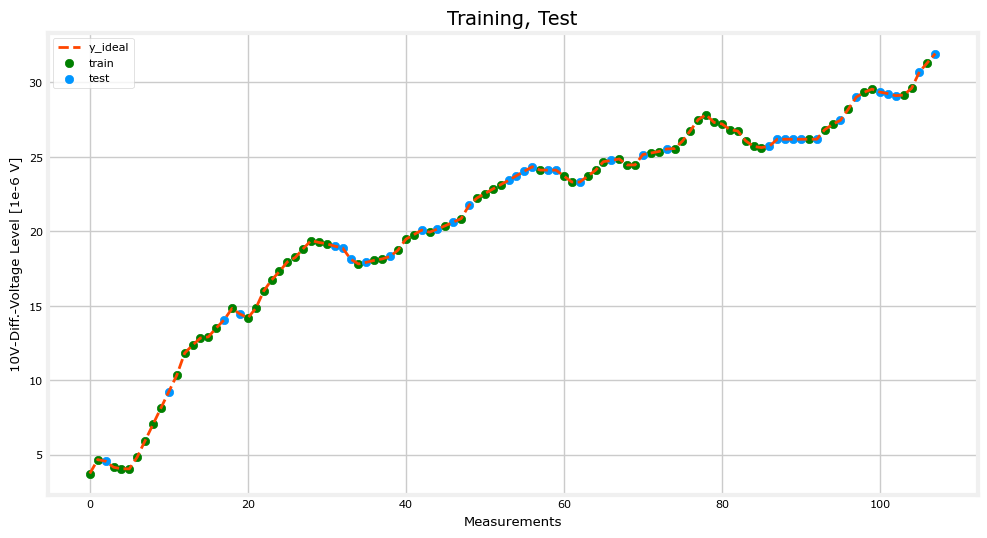

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=2)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("Measurements")
ax.set_ylabel("10V-Diff.-Voltage Level [1e-6 V]")

ax.scatter(X_train, y_train, color = "green",         label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.grid()
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [9]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
        
    err = err / (2*m) 
        
    ### END CODE HERE ### 
    
    return(err)

In [11]:
y_hat = np.array([10.3300121, 26.18188871])
y_tmp = np.array([10.330013, 26.181888])
eval_mse(y_hat, y_tmp)
print(eval_mse(y_hat, y_tmp))

# BEGIN UNIT TEST
test_eval_mse(eval_mse)
# END UNIT TEST

3.2852499935078944e-13
 All tests passed.


<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [13]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [15]:
print(f"training err {err_train:0.16f}, test err {err_test:0.16f}")

training err 0.2693059418325701, test err 0.2795206441807057


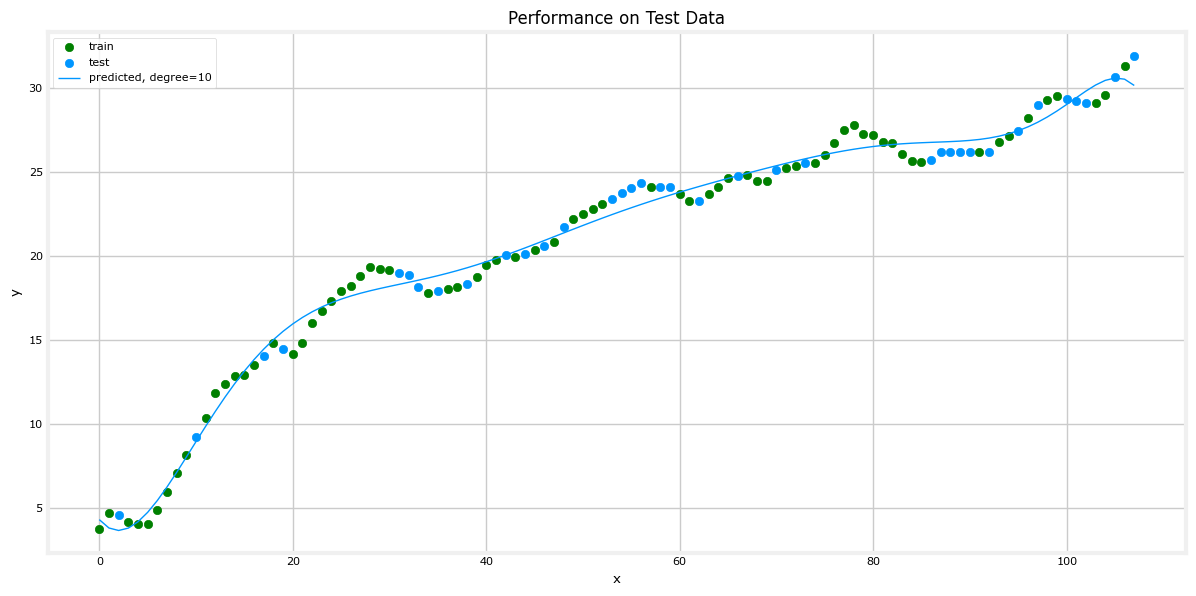

In [17]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),108)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [19]:
# Generate  data
#X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)

# Load data
#data = np.loadtxt("data/110data.txt", delimiter=',')
#X = x_ideal = data[:,0]
#y = y_ideal = data[:,1]

print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (108,) y.shape (108,)
X_train.shape (64,) y_train.shape (64,)
X_cv.shape (22,) y_cv.shape (22,)
X_test.shape (22,) y_test.shape (22,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

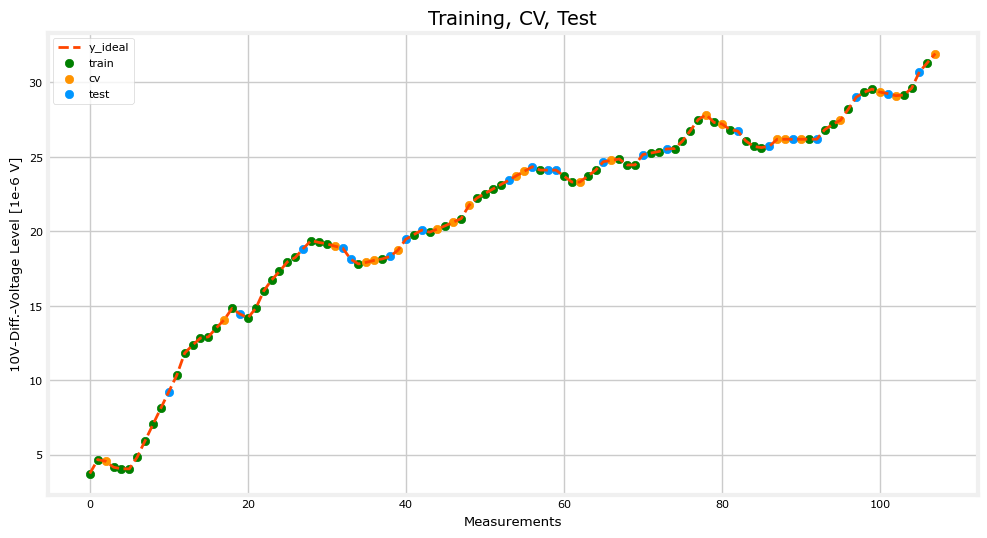

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=2)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("Measurements")
ax.set_ylabel("10V-Diff.-Voltage Level [1e-6 V]")

ax.scatter(X_train, y_train, color = "green",         label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
ax.grid()
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [117]:
max_degree = 10
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),108)  
y_pred = np.zeros((108,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

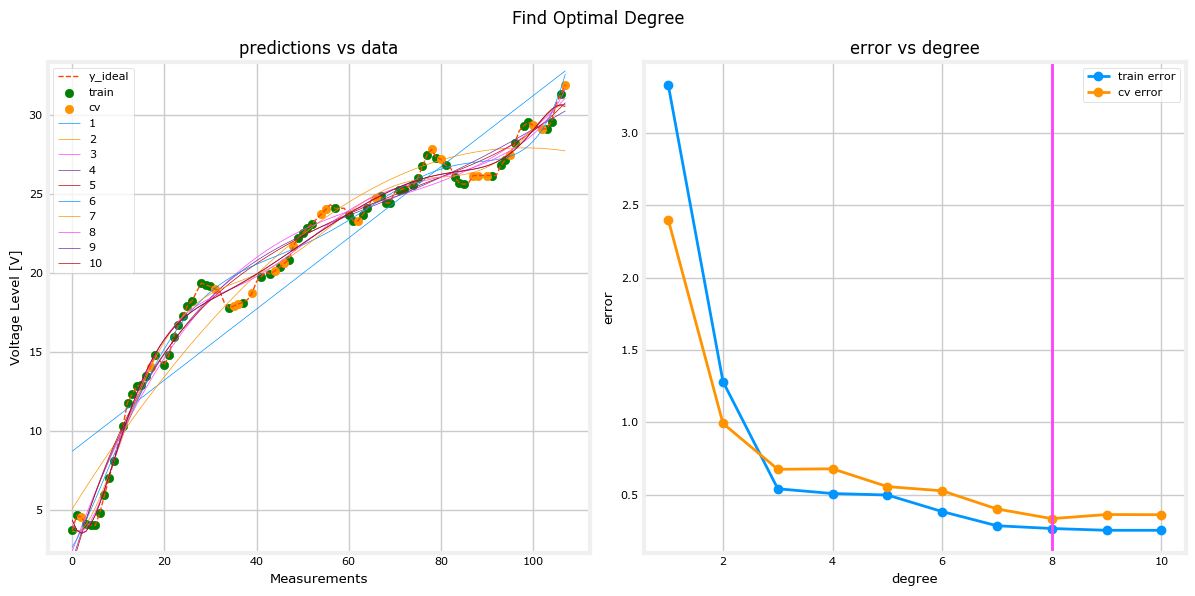

In [119]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

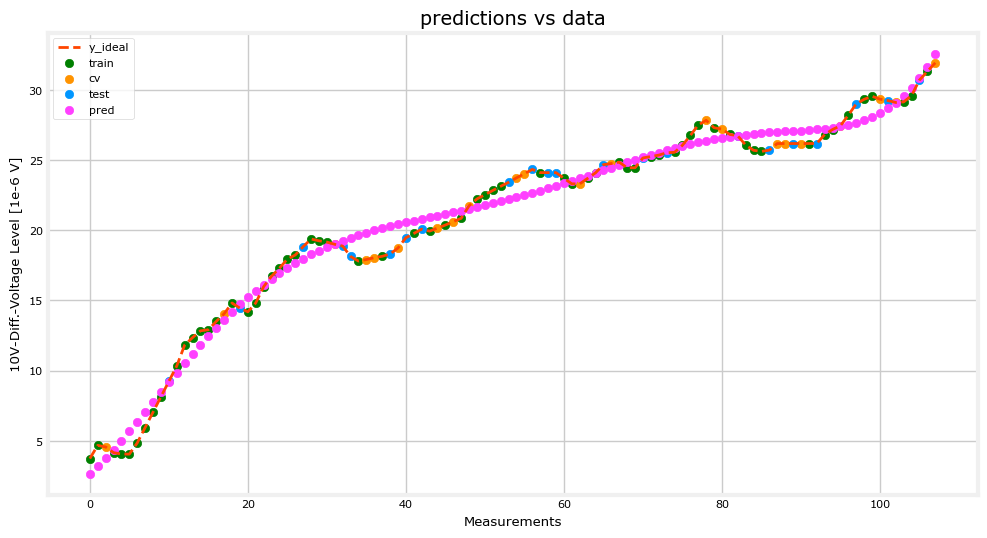

In [121]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=2)
ax.set_title("predictions vs data",fontsize = 14)
ax.set_xlabel("Measurements")
ax.set_ylabel("10V-Diff.-Voltage Level [1e-6 V]")

ax.scatter(X_train, y_train, color = "green",         label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.scatter(x, y_pred[:,5], color = dlc["dlmagenta"],   label="pred")
ax.legend(loc='upper left')
ax.grid()
plt.show()

In [91]:
print(err_train[5])

0.2670480911412161


In [123]:
print(err_cv[5])

0.5276737311203384


In [125]:
from sklearn.metrics import r2_score

print(mean_squared_error(y_ideal, y_pred[:,7]))
print(r2_score(y_ideal, y_pred[:,7]))

0.5459031277984357
0.9890144013345618


In [127]:
from sklearn.metrics import r2_score

print(mean_squared_error(y_ideal, y_pred[:,5]))
print(r2_score(y_ideal, y_pred[:,5]))

0.860228176483018
0.9826890138078976


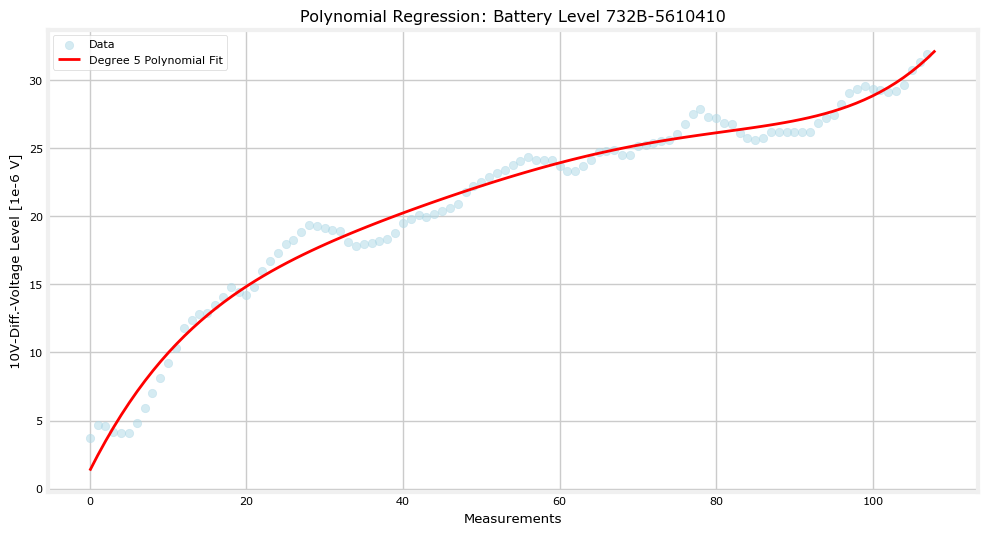

Prediction formula: y = 1.32710945 + 1.14197909 * x^1 + -0.03349323 * x^2 + 0.00061517 * x^3 + -0.00000573 * x^4 + 0.00000002 * x^5


In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Generate some nonlinear data
#np.random.seed(0)
#X = np.linspace(0, 10, 100).reshape(-1, 1)
#y = 5 * X**3 - 2 * X**2 + X + 10 + 1000 * np.random.randn(100, 1)
X = x_ideal.reshape(-1, 1)
y = y_ideal.reshape(-1, 1)


# Transform features to polynomial (degree 5)
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)

# Fit the linear model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

a = len(x_ideal)
# Make predictions
X_plot = np.linspace(0, a, a).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_pred = model.predict(X_plot_poly)

# Plot the data and the prediction
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.scatter(X, y, color='lightblue', label='Data', alpha=0.5)
plt.plot(X_plot, y_pred, color='red', linewidth=2, label='Degree 5 Polynomial Fit')
plt.xlabel('Measurements')
plt.ylabel('10V-Diff.-Voltage Level [1e-6 V]')
plt.title('Polynomial Regression: Battery Level 732B-5610410')
plt.legend()
plt.grid()
plt.show()

# Print polynomial formula
coeffs = model.coef_.flatten()
intercept = model.intercept_[0]
terms = [f"{coeffs[i]:.8f} * x^{i}" for i in range(1, len(coeffs))]
formula = " + ".join(terms)
print(f"Prediction formula: y = {intercept:.8f} + {formula}")


The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [131]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()), a) 
y_pred = np.zeros((a, num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

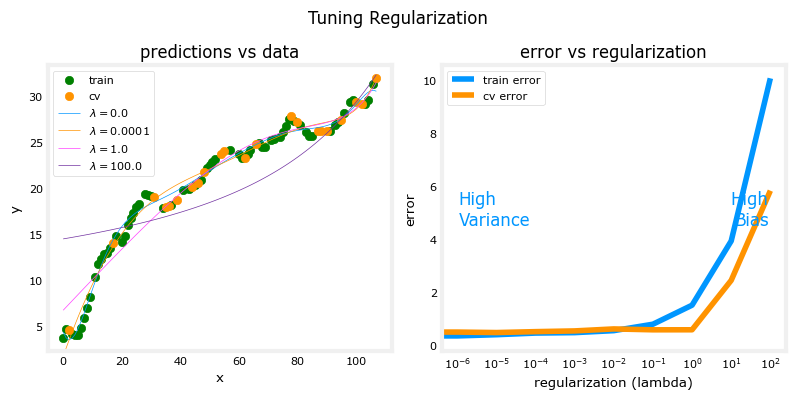

In [133]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

In [135]:
m = len(x_ideal)
lambda_opt = lambda_range[optimal_reg_idx]
lambda_coeff = lambda_opt/m
coeffs_opt = lambda_coeff * coeffs
coeffs_new = coeffs - coeffs_opt
print(lambda_opt)
print(lambda_coeff)
print(coeffs)
print(coeffs_opt)
print(coeffs_new)

0.0
0.0
[ 0.00e+00  1.14e+00 -3.35e-02  6.15e-04 -5.73e-06  2.06e-08]
[ 0.  0. -0.  0. -0.  0.]
[ 0.00e+00  1.14e+00 -3.35e-02  6.15e-04 -5.73e-06  2.06e-08]


In [137]:
# Print regularized polynomial formula
#coeffs = model.coef_.flatten()

intercept = model.intercept_[0]
terms = [f"{coeffs_new[i]:.8f} * x^{i}" for i in range(1, len(coeffs))]
formula = " + ".join(terms)
print(f"Prediction of the regularized formula: y = {intercept:.8f} + {formula}")

Prediction of the regularized formula: y = 1.32710945 + 1.14197909 * x^1 + -0.03349323 * x^2 + 0.00061517 * x^3 + -0.00000573 * x^4 + 0.00000002 * x^5


In [ ]:
Prediction formula: y = 1.32710945 + 1.14197909 * x^1 + -0.03349323 * x^2 + 0.00061517 * x^3 + -0.00000573 * x^4 + 0.00000002 * x^5

For predicted Measure Number = 108, prediction is 32.69287190 1e-6 V
For predicted Measure Number = 109, prediction is 33.34941599 1e-6 V
For predicted Measure Number = 110, prediction is 34.06221869 1e-6 V
For predicted Measure Number = 111, prediction is 34.83495378 1e-6 V
For predicted Measure Number = 112, prediction is 35.67143646 1e-6 V
For predicted Measure Number = 113, prediction is 36.57562600 1e-6 V
For predicted Measure Number = 114, prediction is 37.55162829 1e-6 V
For predicted Measure Number = 115, prediction is 38.60369842 1e-6 V
For predicted Measure Number = 116, prediction is 39.73624326 1e-6 V
For predicted Measure Number = 117, prediction is 40.95382403 1e-6 V
For predicted Measure Number = 118, prediction is 42.26115892 1e-6 V
For predicted Measure Number = 119, prediction is 43.66312561 1e-6 V



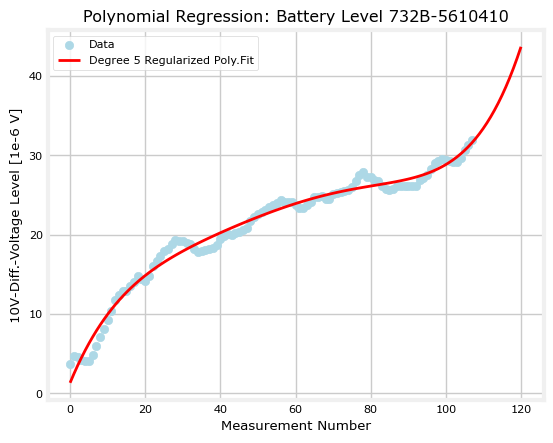

In [149]:
# Regularized predictions
#X_plot = np.linspace(0, 110, 200).reshape(-1, 1)
#X_plot_poly = poly.transform(X_plot)
#y_pred = model.predict(X_plot_poly)

#print(y_pred_opt.shape)
a = 12
c = len(x_ideal)

x_plot = np.linspace(0, c + a, c + a)
y_pred_opt = intercept + coeffs_new[1] * x_plot + coeffs_new[2] * x_plot**2 + coeffs_new[3] * x_plot**3 + coeffs_new[4] * x_plot**4 + coeffs_new[5] * x_plot**5

for idx, i in enumerate(range(c, c + a)):
    
    print(f"For predicted Measure Number = {i}, prediction is {y_pred_opt[i]:.8f} 1e-6 V")
    
print()
# Plot the data and the regularized prediction
plt.plot(figsize=(10,5))
#fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.scatter(X, y, color='lightblue', label='Data', alpha=1)
plt.plot(x_plot, y_pred_opt, color='red', linewidth=2, label='Degree 5 Regularized Poly.Fit')
plt.xlabel('Measurement Number')
plt.ylabel('10V-Diff.-Voltage Level [1e-6 V]')
plt.title('Polynomial Regression: Battery Level 732B-5610410')
plt.legend()
plt.grid()
plt.show()

In [151]:
#a = 12
#c = len(x_plot)
#print(c)
#predict = np.zeros(a)
for idx, i in enumerate(range(c, c + a)):
    #print(idx, i)
    print(f"{y_pred_opt[i]:.8f}")

32.69287190
33.34941599
34.06221869
34.83495378
35.67143646
36.57562600
37.55162829
38.60369842
39.73624326
40.95382403
42.26115892
43.66312561


Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

In [ ]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.
